In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import jax.random as random
import pickle
import seaborn as sns 
from statannot import add_stat_annotation
import scipy.stats as stats
import umap
import tqdm
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt

## Set this to disable JAX from preallocating memory
#import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

from datasets import *
from training_setup import *
from training import *
from utils import *
from analysis_utils import *

In [2]:
DATA_PATH="./"
SAVE_PATH="./"
MODEL_PATH="./"

In [3]:
df = pd.read_csv(f"{DATA_PATH}/veres_pancreatic_remove_top2a.csv", index_col=0)
total_timepoints = len(df["time"].unique())
timepoint_map={k:v for k,v in zip(np.arange(total_timepoints), sorted(df["time"].unique()))}
rev_timepoint_map={k:v for k,v in zip(sorted(df["time"].unique()), np.arange(total_timepoints))}
df["time"] = df["time"].map(rev_timepoint_map)

train_tps_idx = [0, 1, 2, 4, 5, 7]
val_tps_idx = [3,6]

train_tps = train_tps_idx
val_tps = val_tps_idx

timepoints_sorted =  sorted(df["time"].unique().tolist())
    
train_data = df[df["time"].isin(train_tps)].iloc[:,:]
val_data = df[df["time"].isin(val_tps)].iloc[:,:]

z_score=False

if z_score:
    train_data = z_score_norm(train_data)
    val_data = z_score_norm(val_data)

train_data.shape, val_data.shape, train_data["time"].unique(), val_data["time"].unique()

((32784, 1923), (18490, 1923), array([0, 1, 2, 4, 5, 7]), array([3, 6]))

In [4]:
meta=pd.read_csv(f"{DATA_PATH}/GSE114412_Stage_5.all.cell_metadata.tsv", index_col="library.barcode", sep="\t")

In [5]:
train=False

vae_latent_dim=10
lr=1e-4
vae_lr=1e-4
dec_hidden_dim=50
td_sched=6
vae_epochs=100
ferryman_lr=1e-4
epochs=10 
num_sde=10
paths_reuse=5
steps_num=100
vae_enc_hidden_dim=[512,256,128]
vae_dec_hidden_dim=[512,256,128]
# vae_hidden_dim = [200]
batch_size=512
vae_batch_size=32
vae_t_dim=16
t_dim=16
f_val=7
ferryman_hidden_dim=100
death_importance_rates=1
vae_input_dim=train_data.iloc[:,:-1].shape[-1]


if train:
    train_dataset = Input_Dataset(x=train_data, meta=None, meta_celltype_column=None, splitting_births_frac=0.9,
                            steps_num=steps_num, val_split=False, death_importance_rate=death_importance_rates, f_val=f_val)

    ts = Training_Setup(dataset=train_dataset, dataset_name="pancreatic", hidden_dim=[dec_hidden_dim,dec_hidden_dim,dec_hidden_dim], 
                        dec_hidden_size=[dec_hidden_dim,dec_hidden_dim,dec_hidden_dim,1],vae_epochs=vae_epochs, 
                        epochs=epochs,  num_sde=num_sde, paths_reuse=paths_reuse, reality_coefficient=0.2, 
                        ipf_mask_dead=True, t_dim=t_dim, batch_size=batch_size, vae_batch_size=vae_batch_size,
                        vae_input_dim=vae_input_dim, vae_enc_hidden_dim=vae_enc_hidden_dim, vae_t_dim=vae_t_dim,
                        vae_dec_hidden_dim = vae_dec_hidden_dim,vae_latent_dim=vae_latent_dim,
                        ferryman_hidden_dim=[ferryman_hidden_dim, ferryman_hidden_dim,ferryman_hidden_dim, ferryman_hidden_dim,ferryman_hidden_dim,])

    tr = Trainer(dataset=train_dataset, ts=ts,key=random.PRNGKey(0), lr=lr, vae_lr=vae_lr, ferryman_lr=ferryman_lr, ferryman_coeff=1)

    tr_model = tr.train(td_schedule=[1]*td_sched, project_name="pancreatic")

    train_recon, train_latent, val_recon, val_latent = get_model_latents(train_data, val_data, ts, tr_model)

else:
    train_dataset = Input_Dataset(x=train_data, meta=None, meta_celltype_column=None, splitting_births_frac=0.9,
                            steps_num=steps_num, val_split=False, death_importance_rate=death_importance_rates)

    ts = Training_Setup(dataset=train_dataset, dataset_name="pancreatic", hidden_dim=[dec_hidden_dim,dec_hidden_dim,dec_hidden_dim], 
                        dec_hidden_size=[dec_hidden_dim,dec_hidden_dim,dec_hidden_dim,1],vae_epochs=vae_epochs, 
                        epochs=epochs,  num_sde=num_sde, paths_reuse=paths_reuse, reality_coefficient=0.2, 
                        ipf_mask_dead=True, t_dim=t_dim, batch_size=batch_size, vae_batch_size=vae_batch_size,
                        vae_input_dim=vae_input_dim, vae_enc_hidden_dim=vae_enc_hidden_dim, vae_t_dim=vae_t_dim,
                        vae_dec_hidden_dim = vae_dec_hidden_dim,vae_latent_dim=vae_latent_dim,
                        ferryman_hidden_dim=[ferryman_hidden_dim, ferryman_hidden_dim, ferryman_hidden_dim])

    tr = Trainer(dataset=train_dataset, ts=ts,key=random.PRNGKey(0), lr=lr, vae_lr=vae_lr, ferryman_lr=ferryman_lr, ferryman_coeff=1)
    
    with open(f"{MODEL_PATH}/train_veres_3_6_heldout_predictions.pkl","rb") as f:
        model_params = pickle.load(f)
        
    tr_model = tr
    tr_model.vae_params = model_params["vae_params"]
    tr_model.training_setup.state[1]["forward"] = model_params["forward"]
    tr_model.training_setup.state[1]["backward"] = model_params["backward"]
    tr_model.training_setup.state[1]["ferryman"] = model_params["ferryman"]
    train_recon, train_latent, val_recon, val_latent = get_model_latents(train_data, val_data, ts, tr_model)
    train_dataset.update_data_info(train_latent, None)
    ts.sde.killer = train_dataset.killing_function()

### Result analyses

1. Visualize VAE latents and reconstructed cell

In [11]:
mapper = umap.UMAP().fit(val_latent.values[:,:-1])
val_pred_latent = mapper.transform(val_latent.values[:,:-1])

mapper = umap.UMAP().fit(val_data.values[:,:-1])
val_preg_orig = mapper.transform(val_data.values[:,:-1])
val_pred_logits = mapper.transform(val_recon.values[:,:-1])

Text(0.5, 1.0, 'held-out data: reconstructed gene expression')

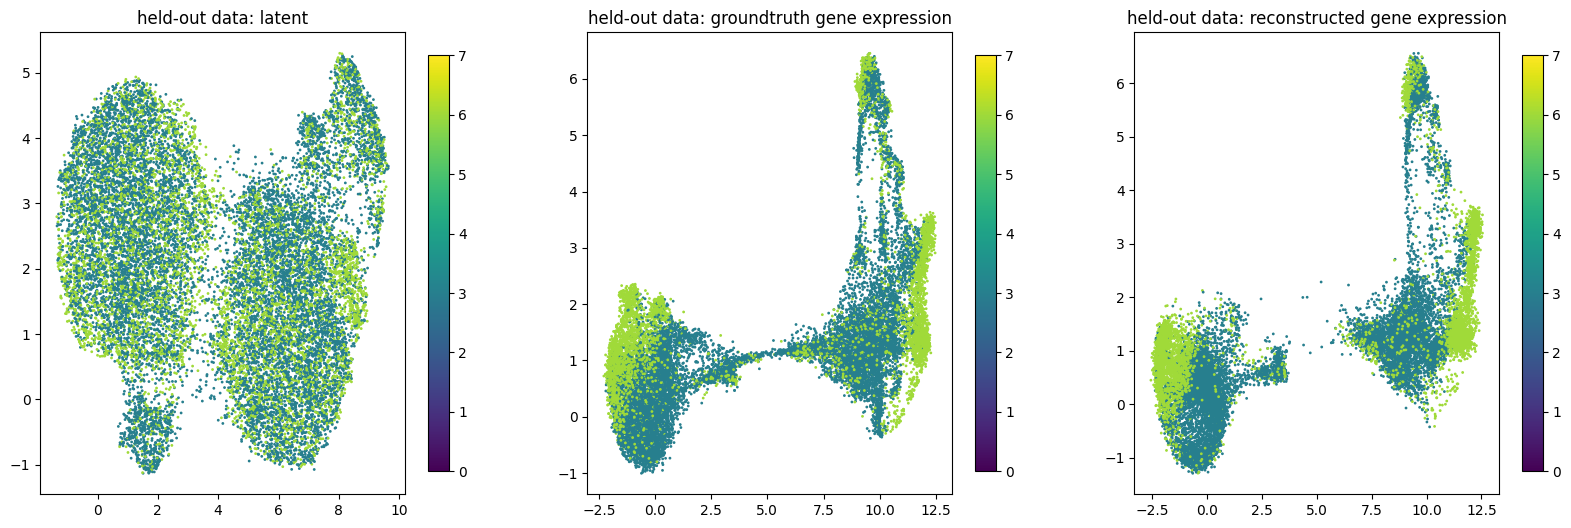

In [12]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize = (20, 6))

sax1 = ax1.scatter(val_pred_latent[:,0], val_pred_latent[:,1], s = 1, c = val_latent.values[:,-1], vmin = min(timepoints_sorted), vmax = max(timepoints_sorted),cmap="viridis")
plt.colorbar(sax1, shrink = 0.9)
ax1.set_title("held-out data: latent")

sax2 = ax2.scatter(val_preg_orig[:,0], val_preg_orig[:,1], s = 1, c = val_data.values[:,-1], vmin = min(timepoints_sorted), vmax = max(timepoints_sorted),cmap="viridis")
plt.colorbar(sax2, shrink = 0.9)
ax2.set_title("held-out data: groundtruth gene expression")

sax3 = ax3.scatter(val_pred_logits[:,0], val_pred_logits[:,1], s = 1, c = val_recon.values[:,-1], vmin = min(timepoints_sorted), vmax = max(timepoints_sorted),cmap="viridis")
plt.colorbar(sax3, shrink = 0.9)
ax3.set_title("held-out data: reconstructed gene expression")

2. Relative cell population changes 

In [6]:
pred_trajectories, pred_trajectories_alive, timepoints, timepoints_alive, statuses, birth_statuses = get_latent_trajectories(train_dataset,train_latent, timepoints_sorted, tr_model, ts, max_size=2000,t_0_orig=train_tps[0])

# all_mass = df["time"].value_counts().sort_index().values
# predicted_status = np.array([(statuses[int(tr_model.dataset.cells_time(timepoints_sorted[i])*steps_num)].sum().item())/(statuses[int(tr_model.dataset.cells_time(timepoints_sorted[i-1])*steps_num)].sum().item()) for i in range(1,len(timepoints_sorted))])
# predicted_status_norm = (predicted_status - predicted_status.min())/(predicted_status.max() - predicted_status.min())
# groundtruth_status_norm = all_mass[1:]/all_mass[:-1]
# groundtruth_status_norm = (groundtruth_status_norm - groundtruth_status_norm.min())/(groundtruth_status_norm.max()-groundtruth_status_norm.min())

# cell_population_changes = pd.DataFrame({"predicted_status_norm":predicted_status_norm, 
#                                        "groundtruth_status_norm": groundtruth_status_norm})
# cell_population_changes.to_csv(f"{SAVE_PATH}/predictions_vs_groundtruth_cell_status.csv")

cell_population_changes=pd.read_csv(f"{SAVE_PATH}/predictions_vs_groundtruth_cell_status.csv",
                                    index_col=0)
predicted_status_norm = cell_population_changes["predicted_status_norm"]
groundtruth_status_norm = cell_population_changes["groundtruth_status_norm"]

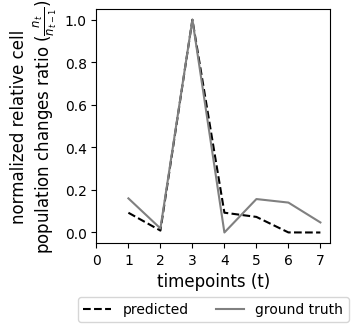

In [7]:
fig, ax = plt.subplots(figsize = (3.5, 3.5))

plt.plot(list(timepoint_map.keys())[1:], predicted_status_norm,label="predicted", color="black", ls='--')
plt.plot(list(timepoint_map.keys())[1:], groundtruth_status_norm, label="ground truth", color="grey")

plt.xticks(timepoints_sorted)
plt.xlabel("timepoints (t)", fontdict={"size":12})
plt.ylabel(f"normalized relative cell\npopulation changes ratio "+r"($\frac{n_{t}}{n_{t-1}})$", fontdict={"size":12})
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.tight_layout()
# plt.savefig(f"{SAVE_PATH}/relative_cell_population_changes_zebrafish.png", dpi=300, bbox_inches='tight')
plt.show()

3. Reconstructed trajectories

In [21]:
predictions = pickle.load(open(f"{SAVE_PATH}/train_veres_3_6_heldout_predictions.pkl","rb"))
simulations = predictions["simulations"]
simulations_1 = simulations[0][1]
val_recon_reshape=simulations_1[simulations_1["time"].isin(val_tps)].values[:,:-1]

mapper = umap.UMAP(random_state=42, n_components=2)
all_true_umap = mapper.fit_transform(pd.concat([train_data, val_data]).iloc[:,:-1].values)
train_true_umap = mapper.transform(train_data.iloc[:,:-1].values)
val_true_umap = mapper.transform(val_data.iloc[:,:-1].values)
val_pred_umap = mapper.transform(val_recon_reshape[:,:])

trajs_umap = []
trajs_umap.append(train_true_umap)
trajs_umap.append(val_true_umap)
trajs_umap.append(val_pred_umap)

tp = sorted(val_data["time"].unique().tolist())
ours_tps = predictions["simulations"][0][1][predictions["simulations"][0][1]["time"].isin(predictions["val_tps"])]["time"].to_list()
import itertools

tps = []
#tps.append(groundtruth.values[:,-1])
tps.append(train_data.values[:,-1])
tps.append(val_data["time"].to_list())
tps.append(ours_tps)

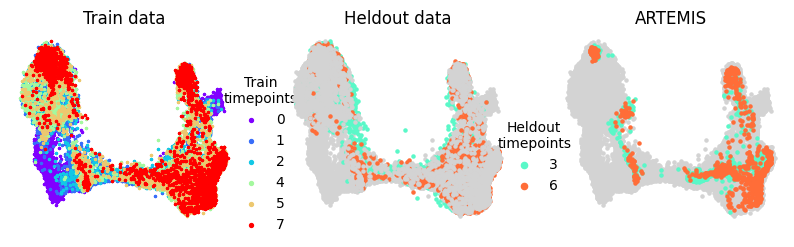

In [28]:

from matplotlib.pyplot import cm
n=8
all_tps = [0,1,2,3,4,5,6,7]
# color = cm.tab20(np.linspace(0, 1, n))
color = cm.rainbow(np.linspace(0, 1, n))

color_dict = {k:v for k,v in zip(timepoints_sorted, color)}
time_map={0:"0",1:"1",2:"2", 3:"3",4:"4",5:"5",6:"6",7:"7"}

test_tps = [3,6]

fig, ax = plt.subplots(1,3,figsize = (10, 2.5))
titles = ["Train data", "Heldout data", "ARTEMIS"] 

for i in range(0,len(trajs_umap)):
    xy_0 = trajs_umap[0]
    df_xy_0 = pd.DataFrame(xy_0)
    df_xy_0["time"] = tps[0]
    df_xy_0 = df_xy_0.sort_values(by=["time"])

    xy = trajs_umap[i]
    df_xy = pd.DataFrame(xy)
    df_xy["time"] = tps[i]
    df_xy = df_xy.sort_values(by=["time"])

    df_comb = pd.concat([df_xy_0, df_xy])
    if i<=1:
        df_comb = df_comb.sort_values(by=["time"])

    for n,g in df_comb.groupby("time", sort=False):
        if n not in test_tps:
            if i==0:
                ax[i].scatter(g[0].values, g[1].values, s = 2, label=time_map[n], color=color_dict[n])
            else:
                ax[i].scatter(g[0].values, g[1].values, s = 5,  c="lightgrey")
        else:
            if i==0:
                continue
            ax[i].scatter(g[0].values, g[1].values, s = 5, label=time_map[n],  color=color_dict[n])#,linestyle='--')
            if i==1:
                
                leg = ax[i].legend(title=f"Heldout\ntimepoints", loc="lower center", bbox_to_anchor=(1.1,0.1), markerscale=2, frameon=False)
                leg.get_title().set_multialignment('center')

    ax[i].set_title(f"{titles[i]}")    
    ax[i].axis('off')

    if i == 0:
        leg = ax[i].legend(title=f"Train\ntimepoints",  loc="lower center", bbox_to_anchor=(1.1,-0.1), markerscale=2, frameon=False)
        leg.get_title().set_multialignment('center')
#plt.legend(bbox_to_anchor=(1.05, 1), markerscale=4, frameon=False)
# plt.savefig(f"{SAVE_PATH}/benchmark_umap.png", dpi=300)
plt.show()

In [9]:
# for held-out timepoints

pred_trajectories_alive_w_time = pd.DataFrame(pred_trajectories_alive)
pred_trajectories_alive_w_time["time"] = timepoints_alive
test_trajs = get_test_trajs(pred_trajectories_alive_w_time, val_data["time"].to_list())

pred_trajectories_w_time = pd.DataFrame(pred_trajectories)
pred_trajectories_w_time["time"] = timepoints
test_trajs_all = get_test_trajs(pred_trajectories_w_time, val_data["time"].to_list())

recon_data = get_reconstructed_trajectory(pred_trajectories_alive, val_data, vae_input_dim, 
                                          vae_dec_hidden_dim,vae_latent_dim, tr_model, timepoints_alive)

mapper = umap.UMAP(random_state=42, n_components=2)
all_true_umap = mapper.fit_transform(pd.concat([train_data, val_data]).iloc[:,:-1].values)

# val_recon_w_time = pd.DataFrame(recon_data)
# val_recon_w_time["time"] = timepoints_alive
# test_recon_trajs = get_test_trajs(val_recon_w_time, val_data["time"].to_list())
# pred_recon_umap = mapper.transform(test_recon_trajs.iloc[:,:-1].values)

4. Visualize cellular drift

In [10]:
train_val_latent = pd.concat([train_latent, val_latent])
all_true_umap_df =  pd.DataFrame(all_true_umap)
all_true_umap_df["time"] = pd.concat([train_data, val_data]).iloc[:,-1].values

params = tr.training_setup.state[1]
score = broadcast(lambda model, params: partial(tr.training_setup.score(model), params), tr.training_setup.model, params)
params_ferryman = tr_model.training_setup.state[1][FERRYMAN]
eval_ferryman= partial(tr_model.training_setup.ferryman.apply, params=params_ferryman, direction=FORWARD)

dec = hk.transform(lambda z: Decoder(output_shape=vae_input_dim, hidden_size=vae_dec_hidden_dim)(z))
rng_seq = hk.PRNGSequence(1)
dec_init_params = dec.init(next(rng_seq), z=np.zeros((val_data.shape[0], vae_latent_dim+vae_t_dim)))

for key in tr_model.vae_params.keys():
    if "dec" in key:
        dec_init_params[key.split("~/")[1]] = tr_model.vae_params[key]

In [13]:
n=8
color = cm.rainbow(np.linspace(0, 1, n))
color_dict = {k:v for k,v in zip(timepoints_sorted, color)}

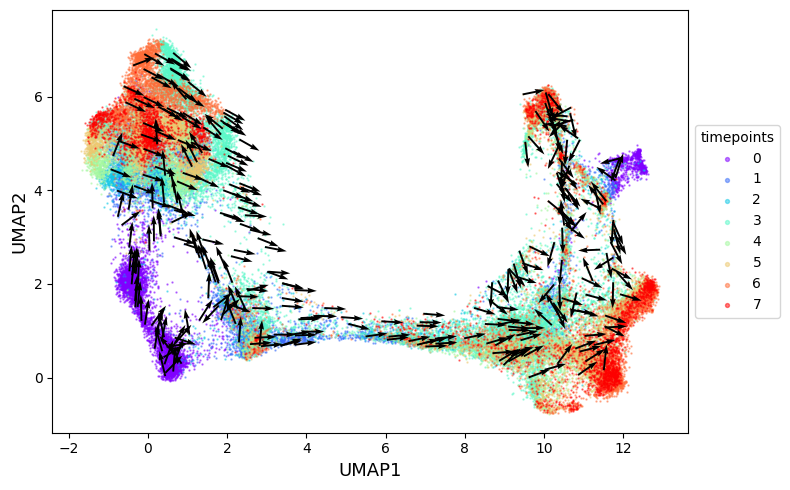

In [15]:
c_l = all_true_umap_df["time"].to_list() 
xg = 10
yg = 20
xgrid = np.linspace(int(all_true_umap[:,0].min()), int(all_true_umap[:,0].max()), xg)
ygrid = np.linspace(int(all_true_umap[:,1].min()), int(all_true_umap[:,1].max()), yg)

fig, ax = plt.subplots(figsize = (8,5))
for n,g in all_true_umap_df.groupby("time"):
    ax.scatter(g[0].values, g[1].values, s = 0.5, label=n, c=color_dict[n], alpha=0.5)#'gray')
plt.legend(markerscale=4, loc='center left', bbox_to_anchor=(1, 0.5), title="timepoints")


for xi in range(xg-1): 
    for yi in range(yg-1): 
        
        xmin, xmax = xgrid[xi], xgrid[xi+1]
        ymin, ymax = ygrid[yi], ygrid[yi+1]
    
        in_x = (all_true_umap[:,0] > xmin) & (all_true_umap[:,0] < xmax)
        in_y = (all_true_umap[:,1] > ymin) & (all_true_umap[:,1] < ymax)
        in_box = in_x & in_y    
        
        if in_box.sum() > 3: 
            ix = np.random.choice(np.where(in_box)[0], max(3, int(in_box.sum() * 0.002)))

            xv = train_val_latent.iloc[:,:-1].values[ix,:]
            xv_t = train_val_latent.iloc[:,-1].values[ix]

            xv_t = np.array([train_dataset.cells_time(xv_t_i) for xv_t_i in xv_t])
            curr_score_t=[]
            for xv_t_i, xv_i in zip(xv_t,xv):
                curr_score_t.append(score["forward"](random.PRNGKey(0), xv_t_i,xv_i.reshape(1,vae_latent_dim))/ts.sde.g(xv_t_i,xv_i))
            curr_score = np.vstack(curr_score_t)

            xv = xv + curr_score

            t_emb = get_timestep_embedding( train_val_latent.iloc[:,-1].values[ix], vae_t_dim)
            pred_traj_t = jnp.concatenate((xv,t_emb),-1)

            xv = dec.apply(dec_init_params, None, pred_traj_t)
            xv = mapper.transform(xv) - all_true_umap[ix,:]
            xv = xv / np.linalg.norm(xv, axis = 1)[:,np.newaxis]

            ax.quiver(all_true_umap[ix,0], all_true_umap[ix,1], xv[:,0], xv[:,1], scale = 1.8, scale_units = 'xy', 
                width = .003)
ax.set_xlabel('UMAP1', fontdict={"size":13})
ax.set_ylabel('UMAP2', fontdict={"size":13})
plt.tight_layout()
# plt.savefig(f"{SAVE_PATH}/cell_drift_original_space.png", dpi=300)
plt.show()

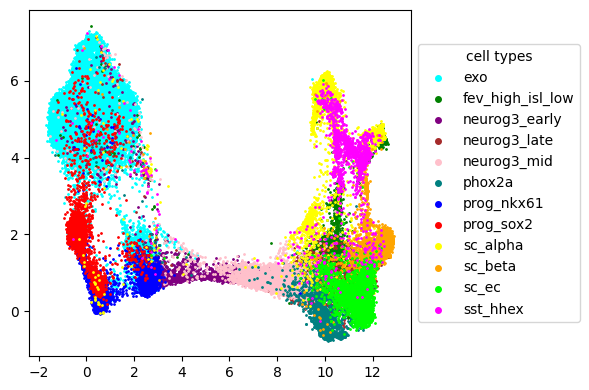

In [18]:
all_true_umap_df["celltype"] = meta.loc[train_data.index]["Assigned_cluster"].to_list()+meta.loc[val_data.index]["Assigned_cluster"].to_list()
all_ct = meta["Assigned_cluster"].unique()
n=len(all_ct)
color= ['#FF0000','#008000','#0000FF','#FFFF00','#00FFFF','#FF00FF','#FFA500','#800080','#A52A2A','#FFC0CB','#008080','#00FF00', '#000080']
color_dict = {k:v for k,v in zip(all_ct, color)}

fig, ax = plt.subplots(figsize = (6,4))
for n,g in all_true_umap_df.groupby("celltype"):
    ax.scatter(g[0].values, g[1].values, s = 1, label=n, c=color_dict[n])#'gray')
plt.legend(markerscale=4, loc='center left', bbox_to_anchor=(1, 0.5), title="cell types")
plt.tight_layout()
plt.show()

In [19]:
# mapper = umap.UMAP(random_state=42, n_components=2)
# all_true_umap = mapper.fit_transform(pd.concat([train_data, val_data]).iloc[:,:-1].values)

val_recon_w_time = pd.DataFrame(recon_data)
val_recon_w_time["time"] = timepoints_alive
pred_recon_all_umap = mapper.transform(val_recon_w_time.values[:,:-1])
val_recon_w_time.columns=train_data.columns

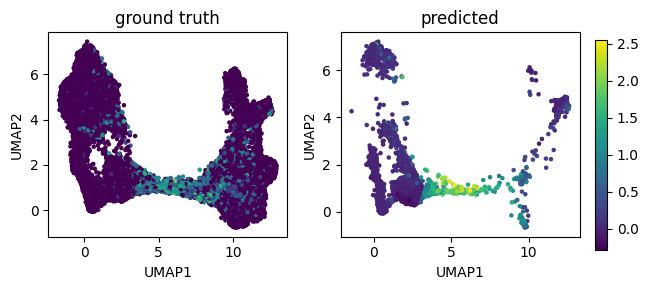

In [21]:
gene="NEUROG3"
all_true_umap_df[gene] = pd.concat([train_data, val_data])[gene].to_list()
fig, ax = plt.subplots(1,2,figsize = (6,3))
ax[0].scatter(all_true_umap_df[0].values, all_true_umap_df[1].values, s = 5, c=all_true_umap_df[gene].to_list(), )#c=color_dict[n])#'gray')
ax[0].set_title("ground truth")
ax[0].set_xlabel("UMAP1")
ax[0].set_ylabel("UMAP2")

sc1 = ax[1].scatter(pred_recon_all_umap[:,0], pred_recon_all_umap[:,1], s = 5, c=val_recon_w_time[gene].to_list())#'gray'
ax[1].set_title("predicted")
ax[1].set_xlabel("UMAP1")
ax[1].set_ylabel("UMAP2")

cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])
fig.colorbar(sc1, cax=cbar_ax)
plt.tight_layout()
# plt.savefig(f"{SAVE_PATH}/{gene}_exp_groundtruth_vs_predicted.png", dpi=300,bbox_inches="tight")

5. Identify drift-genes

In [ ]:
## Uncomment to compute drift genes or load pre-computed drift genes below

# dec = hk.transform(lambda z: Decoder(output_shape=vae_input_dim, hidden_size=vae_dec_hidden_dim)(z))
# rng_seq = hk.PRNGSequence(1)
# dec_init_params = dec.init(next(rng_seq), z=np.zeros((val_data.shape[0], vae_latent_dim+vae_t_dim)))

# for key in tr_model.vae_params.keys():
#     if "dec" in key:
#         dec_init_params[key.split("~/")[1]] = tr_model.vae_params[key]
        
# def decoder_output(z):
#     recon_data = dec.apply(dec_init_params, None, z)
#     return recon_data

# params = tr.training_setup.state[1]
# score = broadcast(lambda model, params: partial(tr.training_setup.score(model), params), tr.training_setup.model, params)

# top_n=20
# drift_genes = {}
# shuffled_drift_genes={}

# for int_t in pred_trajectories_w_time["time"].unique():

#     print ("time:", int_t)
#     shuffled_drift_genes[int_t] = []

#     z_traj = pred_trajectories_w_time[pred_trajectories_w_time["time"]==int_t].values[:,:-1]
#     t_emb = get_timestep_embedding(pred_trajectories_w_time[pred_trajectories_w_time["time"]==int_t].values[:,-1], vae_t_dim)
#     pred_traj_t = jnp.concatenate((z_traj,t_emb),-1)
#     z_score = score["forward"](random.PRNGKey(0), train_dataset.cells_time(int_t), z_traj)
#     z_score_t = jnp.concatenate((z_score, t_emb), -1)

#     #print ("computing jacobian-vector product (jvp)")
#     output, jvp = jax.jvp(decoder_output, (pred_traj_t,), (z_score_t,))
#     jvp_df = pd.DataFrame(jvp, columns=train_data.columns[:-1])

#     # create null distribution by shuffling cells in latent space
#     for i in range(100):
#         z_traj_shuffled = jax.random.permutation(random.PRNGKey(i), z_traj)
#         z_score_shuffled = score["forward"](random.PRNGKey(0), train_dataset.cells_time(int_t), z_traj_shuffled)
#         z_score_shuffled_t = jnp.concatenate((z_score_shuffled, t_emb), -1)
#         output_shuffled, jvp_shuffled = jax.jvp(decoder_output, (pred_traj_t,), (z_score_shuffled_t,))
#         jvp_shuffled_df = pd.DataFrame(jvp_shuffled, columns=train_data.columns[:-1])
#         shuffled_drift_genes[int_t].append(jvp_shuffled_df.mean().to_frame().T) 

#     #print ("identifying drift positive & negative genes")
#     score_pos_genes = jvp_df.mean().sort_values(ascending=False)[:]
#     score_neg_genes = jvp_df.mean().sort_values(ascending=False)[::-1]

#     print ("#positive drift genes:",sum(jvp_df.mean().sort_values(ascending=False)>0))

#     drift_genes[int_t] = {"pos": score_pos_genes, "neg": score_neg_genes}

# with open(f"{SAVE_PATH}/drift_genes.pkl","wb") as f:
#         pickle.dump(drift_genes,f,protocol=pickle.HIGHEST_PROTOCOL)


In [22]:
with open(f"{SAVE_PATH}/drift_genes.pkl","rb") as f:
        drift_genes = pickle.load(f)

In [ ]:
# from scipy.stats import ttest_ind

# for curr_tp in range(12):
#     print ("pos:", curr_tp)
#     drift_genes_t = drift_genes[curr_tp]['pos']

#     drift_gene_pval = []
#     for gene in drift_genes_t.index:
#         if drift_genes_t[gene]<0:
#             continue
#         gene_null_distribution=[]
#         for i in range(100):
#             gene_null_distribution.extend(shuffled_drift_genes[curr_tp][i][gene].to_list())
#         p = ttest_ind([drift_genes_t[gene]], gene_null_distribution, alternative="two-sided",).pvalue
#         drift_gene_pval.append([gene,p])
    
#     drift_gene_pval_df = pd.DataFrame(drift_gene_pval, columns=["gene","pval"])
#     # drift_gene_pval_df.to_csv(f"{SAVE_PATH}/drift_genes_ttest_significance_testing_tp{curr_tp}.csv")

#     print (drift_gene_pval_df[drift_gene_pval_df["gene"].isin(drift_genes[curr_tp]['pos'].index[:20].tolist())])

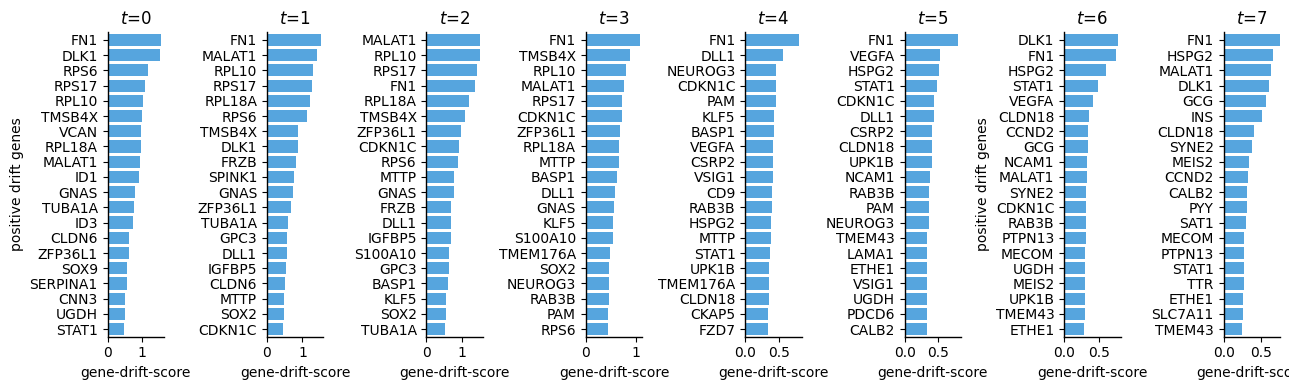

In [24]:
fig, axs = plt.subplots(1,8, figsize=(13, 4))
fig.subplots_adjust(hspace = .5, wspace=.001)
top_n=20
axs = axs.ravel()
i=0
for k,v in drift_genes.items():
    pos_drift_scores = v['pos'].to_frame()[:top_n]
    stage=timepoint_map[k]

    plt.margins(0, 0)
    axs[i].set_title(r'$t$'+f'={k}')
    pos_drift_scores["gene"] = pos_drift_scores.index
    pos_drift_scores.columns=["value","gene"]
    sns.barplot(data=pos_drift_scores, y="gene",x="value", orient="h", ax=axs[i], color="#3fa9f5")# palette="PuBu_r")
    axs[i].set_ylabel('')
    if i ==0 or i==6:
        axs[i].set_ylabel('positive drift genes')
    axs[i].set_xlabel('gene-drift-score')

    for spine in ['top', 'right', 'bottom', 'left']:
        axs[i].spines[spine].set_linewidth(1)
    axs[i].spines[['right', 'top']].set_visible(False)
    i+=1

plt.tight_layout()
# plt.savefig(f"{SAVE_PATH}/positive_drift_genes.png",dpi=300)
plt.show()

6. Get dead-live cell statuses

In [25]:
def get_estimated_death_at_t(t, x_t, x_t_plus_1, status):


    params = tr.training_setup.state[1][FERRYMAN]
    eval_ferryman = partial(tr.training_setup.ferryman.apply, params=params, direction="forward")

    death_threshold = ts.sde.killer(t/train_dataset.steps_num, x_t)
    key, death_threshold = ts.sde.reweight_killing(random.PRNGKey(0), FORWARD, death_threshold, eval_ferryman, x_t, status, t/train_dataset.steps_num, x_t_plus_1)

    return death_threshold
def get_dead_cells(t, trajs, statuses, birth_statuses):

    dead_cells = []

    status_t = statuses[t]
    status_t_plus_1 = statuses[t+1]
    birth_status_t_plus_1 = birth_statuses[t+1]

    estimated_death_threshold = get_estimated_death_at_t(t, trajs[t], trajs[t+1], status_t)

    estimated_death_threshold_dead_cells=[]

    alive_t_idx = np.where(status_t)[0]
    dead_t_plus_1_idx= [] 
    for idx in alive_t_idx:
        if status_t[idx] & ~status_t_plus_1[idx]:
            dead_cells.append(trajs[t][idx])
            dead_t_plus_1_idx.append(idx)
            estimated_death_threshold_dead_cells.append(estimated_death_threshold[idx].item())
        elif birth_status_t_plus_1[idx].item() != 0:
            dead_cells.append(trajs[t][idx])
            dead_t_plus_1_idx.append(idx)
            estimated_death_threshold_dead_cells.append(estimated_death_threshold[idx].item())

    return dead_cells, estimated_death_threshold, estimated_death_threshold_dead_cells, dead_t_plus_1_idx

def get_split_cells(t, statuses, birth_statuses):

    split_cells=[]

    status_t = statuses[t]
    birth_status_t_plus_1 = birth_statuses[t+1]

    alive_t_idx = np.where(status_t)[0]

    for idx in alive_t_idx:
        birth_idx_t_plus_1 = np.where(birth_status_t_plus_1==idx)[0]
        if len(birth_idx_t_plus_1)==0:
            continue
        else:
            if idx == birth_idx_t_plus_1[0]:
                continue
            split_cells.append((idx, (idx,birth_idx_t_plus_1[0])))
    return split_cells

def get_reborn_cells(t, trajs, statuses, birth_statuses):
    # print (t)

    reborn_cells=[]

    status_t = statuses[t]
    status_t_plus_1 = statuses[t+1]
    birth_status_t_plus_1 = birth_statuses[t+1]
    trajs_t_plus_1 = trajs[t+1]

    dead_to_alive = np.logical_and(~status_t, status_t_plus_1)

    dead_to_alive_t_plus_1_idx = np.where(dead_to_alive)[0]

    for idx in dead_to_alive_t_plus_1_idx:
        if birth_status_t_plus_1[idx]==0:
            reborn_cells.append(trajs_t_plus_1[idx])
    
    return reborn_cells

def cell_time_to_real_time(t):
    times_orig = train_dataset.times_orig
    t_real = (t*(times_orig[-1]-times_orig[0]))/train_dataset.steps_num + times_orig[0]
    return t_real

def get_reconstructed_dead_cells(pred_trajectories, val_data, vae_input_dim, vae_dec_hidden_dim, tr_model, timepoints):

    dec = hk.transform(lambda z: Decoder(output_shape=vae_input_dim, hidden_size=vae_dec_hidden_dim)(z))
    rng_seq = hk.PRNGSequence(1)
    dec_init_params = dec.init(next(rng_seq), z=np.zeros((val_data.shape[0], vae_latent_dim+vae_t_dim)))

    
    for key in tr_model.vae_params.keys():
        if "dec" in key:
            dec_init_params[key.split("~/")[1]] = tr_model.vae_params[key]
            
    t_emb = get_timestep_embedding(timepoints, t_dim)
    pred_traj_t = jnp.concatenate((pred_trajectories,t_emb),-1)

    recon_data = dec.apply(dec_init_params, None, pred_traj_t)
    recon_data.shape

    return recon_data

In [26]:
params = tr.training_setup.state[1]
eval_score = broadcast(lambda model, params: partial(tr.training_setup.score(model), params), tr.training_setup.model, params)
params_ferryman = tr_model.training_setup.state[1][FERRYMAN]
eval_ferryman= partial(tr_model.training_setup.ferryman.apply, params=params_ferryman, direction=FORWARD)

train_val_latent = pd.concat([train_latent, val_latent])
val_data_init = train_val_latent[train_val_latent["time"]==timepoints_sorted[0]].iloc[:,:-1].values

max_size=2000

if max_size!=0:
    val_data_init = sample(val_data_init, size = (max_size, ))

print (val_data_init.shape)
trajs, _, statuses, birth_statuses = ts.sde.sample_trajectory(random.PRNGKey(0), FORWARD, val_data_init, eval_score, 
                                                                eval_ferryman, corrector="",  test=False, max_size=max_size)

(2000, 10)


In [27]:
cell_real_time_ordered=True

In [250]:
dead_cell_count = []
dead_cells_per_interval={}
interval_count=0
all_times = list(map(lambda t: int(train_dataset.cells_time(t)*train_dataset.steps_num), timepoints_sorted))

# Get dead cells in each in/media/sayali/External Dr/Sayali/UDSB/src_vae_fbsde/resultsv1.2/params/zebrafishterval defined by measured timepoints
print ("getting dead cells")
for t in tqdm(np.arange(0,train_dataset.steps_num)):#train_dataset.times:

    start_int = all_times[interval_count]
    end_int = all_times[interval_count+1]

    if t==0:
        interval_i=[]
    
    dead_cells, _, _, _ = get_dead_cells(t, trajs, statuses, birth_statuses)
    if len(dead_cells)!=0:
        dead_cells = np.stack(dead_cells)
        dead_cell_count.append(dead_cells.shape[0])

        if not cell_real_time_ordered:
            dead_cell_time = np.round(cell_time_to_real_time(np.array([t]*dead_cells.shape[0])))
        else:
            dead_cell_time = np.array([t]*dead_cells.shape[0])
            
        recon_dead_cells = get_reconstructed_dead_cells(dead_cells, val_data, vae_input_dim, vae_dec_hidden_dim, tr_model, dead_cell_time)      
        interval_i.extend(recon_dead_cells)

    if t+1 == end_int or t==train_dataset.steps_num:
        dead_cells_per_interval[f"{start_int}_{end_int}"] = interval_i
        interval_i=[]
        interval_count+=1

alive_cells_per_interval={}
interval_count=0
all_times = list(map(lambda t: int(train_dataset.cells_time(t)*train_dataset.steps_num), timepoints_sorted))

# Get live cells in each interval defined by measured timepoints
print ("getting live cells")
for t in tqdm(np.arange(0,train_dataset.steps_num+1)):

    start_int = all_times[interval_count]
    end_int = all_times[interval_count+1]

    if t==0:
        interval_i=[]

    alive_cells = trajs[t][statuses[t]]

    if not cell_real_time_ordered:
        alive_cell_time = np.round(cell_time_to_real_time(np.array([t]*alive_cells.shape[0])))
    else:
        alive_cell_time = np.array([t]*alive_cells.shape[0])

    recon_alive_cells = get_reconstructed_dead_cells(alive_cells, val_data, vae_input_dim, vae_dec_hidden_dim, tr_model, alive_cell_time)        
    interval_i.extend(recon_alive_cells)

    if t == end_int or t==train_dataset.steps_num:
        alive_cells_per_interval[f"{start_int}_{end_int}"] = interval_i
        interval_i=[]
        interval_count+=1

100%|██████████| 100/100 [00:01<00:00, 69.92it/s]


In [ ]:
for k,v in dead_cells_per_interval.items():
    print (k, len(v))
for k,v in alive_cells_per_interval.items():
    print (k, len(v))

In [29]:
import tqdm 

reborn_cell_count=[]
alive_cell_count=[]
dead_cell_count=[]
split_cell_count=[]

for i in tqdm.tqdm(range(5)):
    reborn_cell_count.append([])
    alive_cell_count.append([])
    dead_cell_count.append([])
    split_cell_count.append([])

    trajs, _, statuses, birth_statuses = ts.sde.sample_trajectory(random.PRNGKey(0), FORWARD, val_data_init, eval_score, 
                                                                    eval_ferryman, corrector="",  test=False, max_size=max_size)

    for t in tqdm.tqdm(np.arange(0,train_dataset.steps_num)):#train_dataset.times:
        
        reborn_cells = get_reborn_cells(t, trajs, statuses, birth_statuses)
        reborn_cell_count[-1].append(len(reborn_cells))

        alive_cells = trajs[t][statuses[t]]
        alive_cell_count[-1].append(len(alive_cells))

        dead_cells, _, _, _ = get_dead_cells(t, trajs, statuses, birth_statuses)
        dead_cell_count[-1].append(len(dead_cells))
        
        split_cells = get_split_cells(t, statuses, birth_statuses)
        split_cell_count[-1].append(len(split_cells))

100%|██████████| 5/5 [24:15<00:00, 291.09s/it]


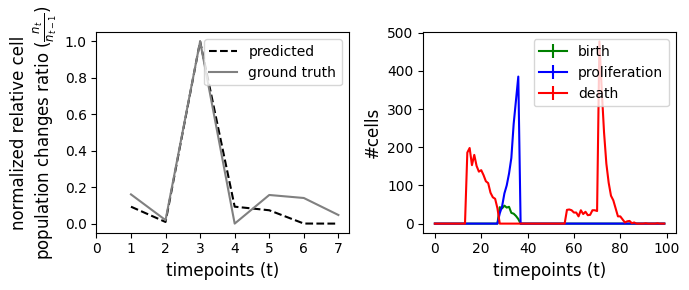

In [34]:
fig, ax = plt.subplots(1,2,figsize = (7, 3))

ax[0].plot(list(timepoint_map.keys())[1:], predicted_status_norm,label="predicted", color="black", ls='--')
ax[0].plot(list(timepoint_map.keys())[1:], groundtruth_status_norm, label="ground truth", color="grey")
ax[0].set_xticks(timepoints_sorted, timepoints_sorted)
ax[0].set_xlabel("timepoints (t)", fontdict={"size":12})
ax[0].set_ylabel(f"normalized relative cell\npopulation changes ratio "+r"($\frac{n_{t}}{n_{t-1}})$", fontdict={"size":12})
ax[0].legend(loc="upper right")
ax[0].set_title(" ")

ax[1].errorbar(x = np.arange(100), y=pd.DataFrame(reborn_cell_count).mean(), yerr=pd.DataFrame(reborn_cell_count).std(), label="birth", c="green")
ax[1].errorbar(x = np.arange(100), y=pd.DataFrame(split_cell_count).mean(), yerr=pd.DataFrame(split_cell_count).std(), label="proliferation",c="blue")
ax[1].errorbar(x = np.arange(100), y=pd.DataFrame(dead_cell_count).mean(), yerr=pd.DataFrame(dead_cell_count).std(),label="death",c="red")
ax[1].set_xlabel("timepoints (t)",fontdict={"size":12})
ax[1].set_ylabel("#cells",fontdict={"size":12})
plt.legend()
plt.tight_layout()
# plt.savefig(f"{SAVE_PATH}/cell_proportion_and_cell_status_wo_p.png",dpi=300)